In [1]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# dataset functions
from dataset import load_util

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.simclr import *
from models.simclr.transforms import *
from models.rotnet.rotnet import *
from models.rotnet.IDEC import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

Versions:
torch: 1.8.1+cu111
torchvision: 0.9.1+cu111
numpy: 1.19.5
scikit-learn: 0.24.1
Using device:  cuda


In [4]:
# specify learning params
batch_size = 128
learning_rate = 0.001
epochs = 150

# training

train = True

# load datasets and create dataloaders
data, testdata = load_util.load_cifar('./data', download=True, for_model='SimCLR')
data_percent = 0.4

Files already downloaded and verified


### Clustering and PCA of the pretrained RotNet model

In [5]:
def encode_batchwise(dataloader, model, device, layer, flatten=False):
    """ Utility function for embedding the whole data set in a mini-batch fashion
    """
    embeddings = []
    labels = []
    for batch, blabels in dataloader:
        batch_data = batch.to(device)
        feats = model(batch_data, layer)
        if flatten:
            embeddings.append(feats.flatten(start_dim=1).detach().cpu())
        else:
            embeddings.append(feats.detach().cpu())
        labels = labels + blabels.tolist()
    return torch.cat(embeddings, dim=0).numpy(), labels

In [6]:
test_data = load_util.load_custom_cifar('./data', download=False, train=False, data_percent=1.0, for_model='SimCLR')
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=False)

In [7]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}

In [8]:
# for i in range(3):
model = RotNet(num_classes=4)

state_dict = torch.load(f'trained_models/pretrained_RotNet_features.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

print(model.feat_block_names)

['conv1', 'conv2', 'conv3', 'pooling', 'features', 'classifier']


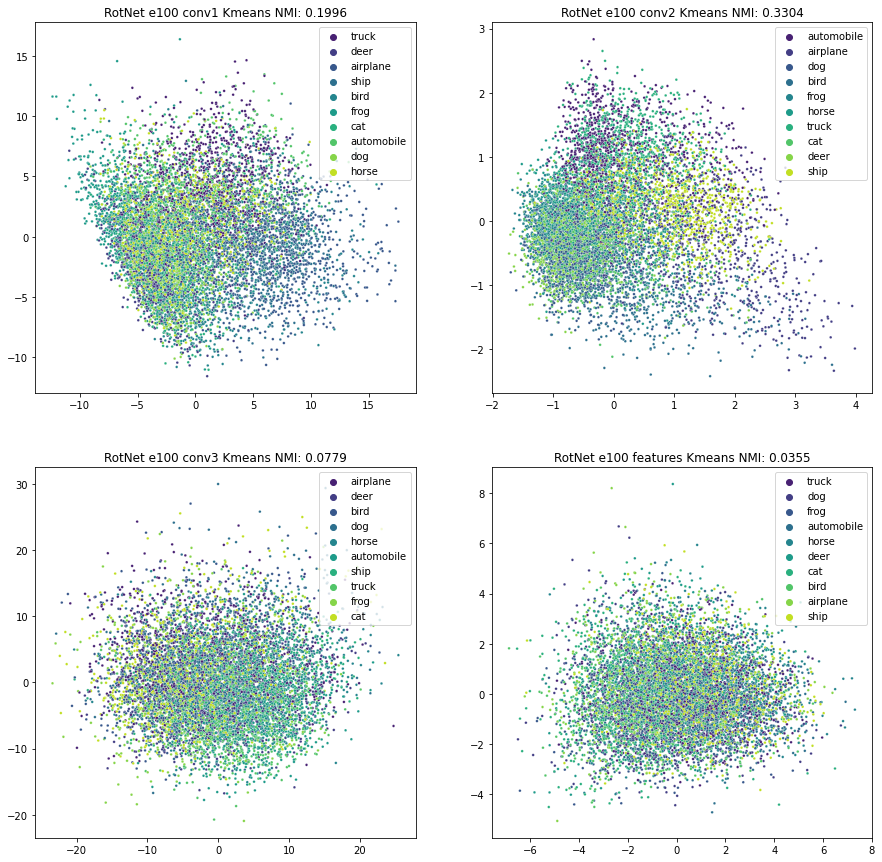

In [11]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    ver = f'RotNet e100 {layer}'
    embedded_data, labels = encode_batchwise(testloader, model, device, [layer], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embedded_data)

    axes[i].set_title(f'{ver} Kmeans NMI: {nmi:.4f}')
    sns.scatterplot(ax=axes[i], x=reduced_data[:,0], y=reduced_data[:,1], hue=lable_classes, s=7, palette='viridis')

RotNet model has "Network in Network" structure, which means it consists of multiple "smaller" convolutional networks. Each convolutional block returns different features. I have tried to perform kmeans on each of the block, and 2d block showed the best results, so I took it's features for later IDEC training.

I have a question to the convolutional networks output: it returns me a list of different activations for an image (I have plotted the activations for one of the images below). To perform kmeans, I just flattened the vector and used the whole output. Is there a better way to use the convolutional network output for the IDEC? Probably some kind of dimensionality reduction? 

### Visualizing activations

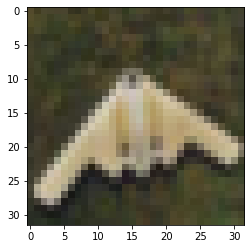

In [76]:
img, label = test_data.__getitem__(5)
plt.imshow(img.numpy().transpose(1,2,0))

In [77]:
img1 = img.unsqueeze(0).to(device)

img 5 conv1


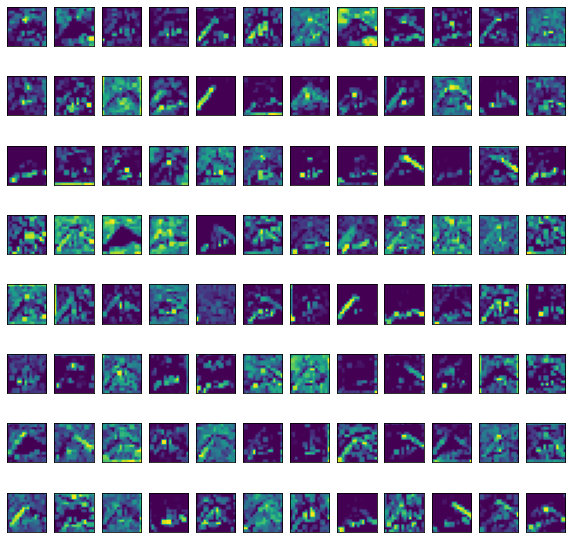

img 5 conv2


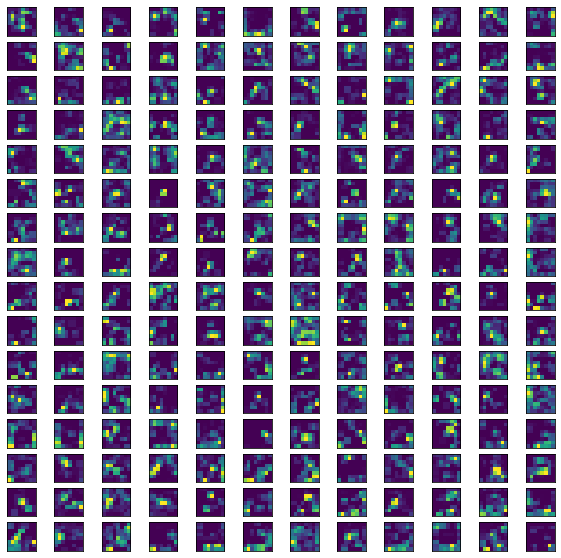

img 5 conv3


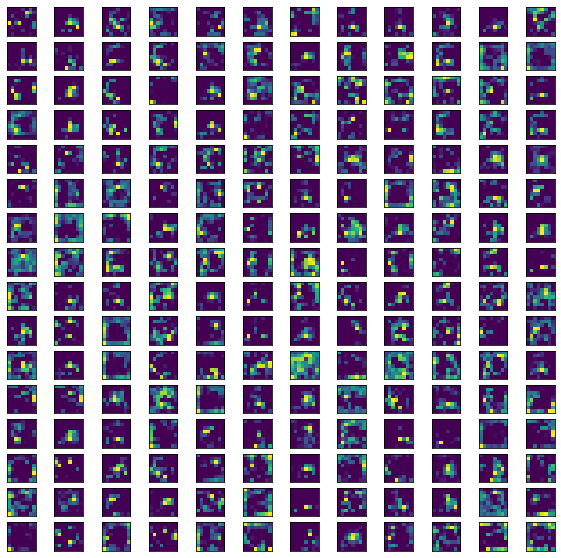

img 5 conv4


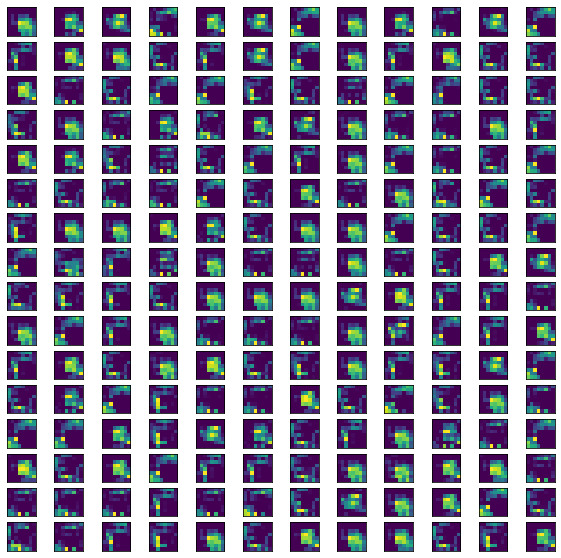

In [109]:
for i, layer in enumerate(model.feat_block_names[:-1]):
    print(f'img 5 {layer}')
    embedded_img = model(img1, [layer]).cpu().detach().numpy()[0]
    row_num = int(embedded_img.shape[0]/12)
    
    fig, axes = plt.subplots(row_num,12, figsize=(10,10))
    axes = axes.flatten()

    for i, img in enumerate(embedded_img):
        axes[i].tick_params(bottom=False, left=False)
        axes[i].set(xticklabels=[], yticklabels=[])
        axes[i].imshow(img)

    plt.show()

### RotNet IDEC

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


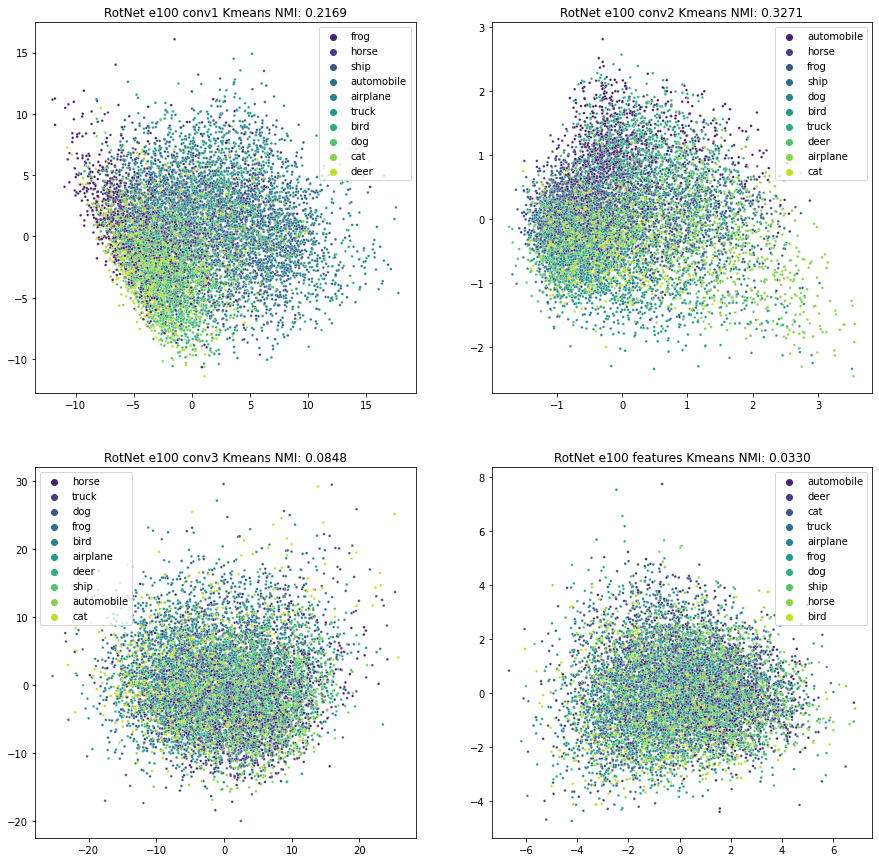

In [26]:
rotnet = IDEC(model=RotNet(num_classes=4))
state_dict = torch.load(f'trained_models/IDEC_RotNet_e100_features.pth', map_location=device)
rotnet.load_state_dict(state_dict)
rotnet.to(device)

fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    ver = f'RotNet e100 {layer}'
    embedded_data, labels = encode_batchwise(testloader, model, device, [layer], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embedded_data)

    axes[i].set_title(f'{ver} Kmeans NMI: {nmi:.4f}')
    sns.scatterplot(ax=axes[i], x=reduced_data[:,0], y=reduced_data[:,1], hue=lable_classes, s=7, palette='viridis')

In [18]:
vers = ['pretrained_RotNet_features', 'IDEC_RotNet_e100_features']
pcas = {}
nmis = {}

In [23]:
for ver in vers:
    print(ver)
    if 'IDEC' not in ver:
        rotnet = RotNet(num_classes=4)
    else:
        rotnet = IDEC(model=RotNet(num_classes=4))

    state_dict = torch.load(f'trained_models/{ver}.pth', map_location=device)
    rotnet.load_state_dict(state_dict)
    rotnet.to(device)
    
    if 'IDEC' not in ver:
        model = rotnet
    else:
        model = rotnet.model
    
    embedded_data, labels = model.encode_batchwise(testloader, device, ['features'], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmis[ver] = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    pcas[ver] = pca.fit_transform(embedded_data)

pretrained_RotNet_features
IDEC_RotNet_e100_features


D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


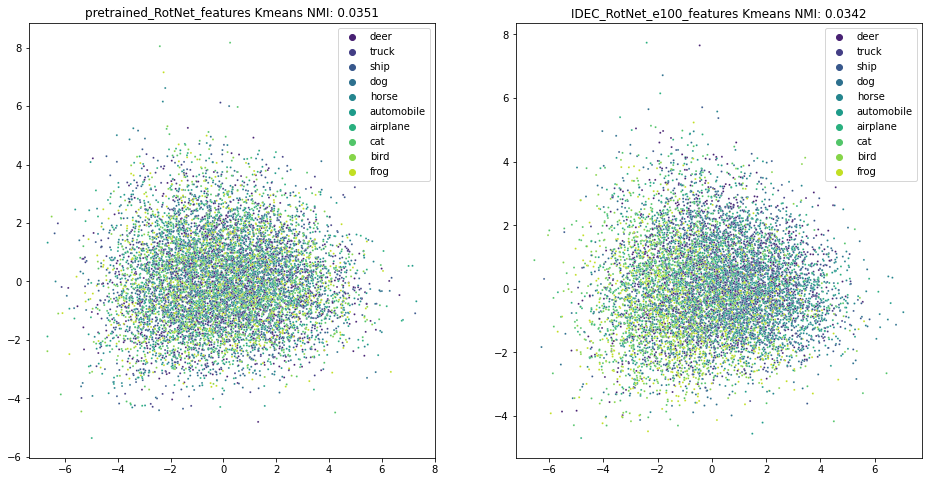

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes = axes.flatten()

for i, ver in enumerate(vers):
    axes[i].set_title(f'{ver} Kmeans NMI: {nmis[ver]:.4f}')
    sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], hue=lable_classes, s=4, palette='viridis')

I feel like classification results here rely on kmeans and pca run heavily. Sometimes IDEC with 30 epochs looks better than 60 epochs, sometimes worse, depending on the kmeans and pca runs. If one looks at the separate classes plots, it is seen that training with IDEC haven't brought anything. Is it possible that the reason is that I shouldn't use convolutional network output directly? Or it should be fine if kmeans on pretrained data embedded with flattening achieves 30%, and I just made some mistake here? I am not sure about IDEC training because of the specific network training and would like to discuss it on Friday in detail.

I also hope that as in the case with SimCLR better pretrain accuracy can be achieved with training on the whole dataset (I use 40% of the data in both of the cases)

pretrained_RotNet_features class representation


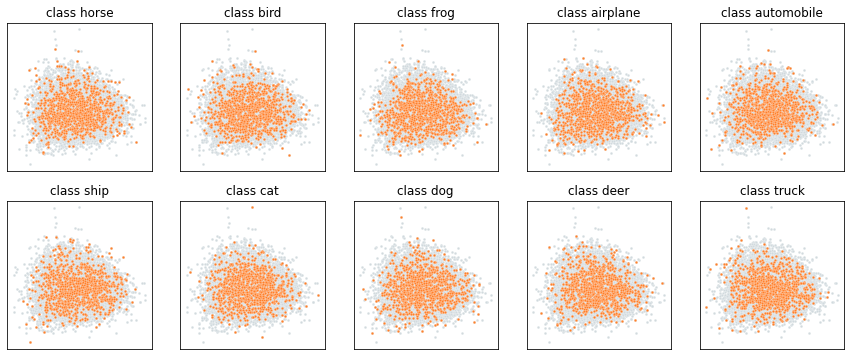

IDEC_RotNet_e100_features class representation


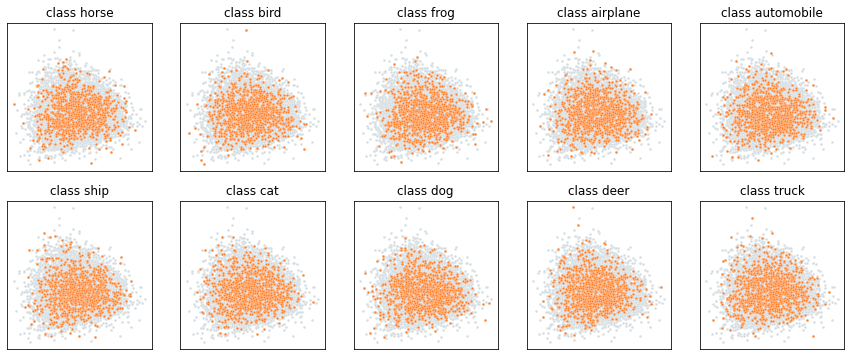

In [28]:
lc = np.array(lable_classes)

for ver in vers:
    print(f'{ver} class representation')
    fig, axes = plt.subplots(2,5, figsize=(15,6))
    axes = axes.flatten()

    for i, c in enumerate(set(lable_classes)):
        ids = np.where(lc==c)[0]
        axes[i].set(title=f'class {c}')
        axes[i].tick_params(bottom=False, left=False)
        axes[i].set(xticklabels=[], yticklabels=[])
        sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], s=7, color='#d1dade')  
        sns.scatterplot(ax=axes[i], x=pcas[ver][ids,0], y=pcas[ver][ids,1], s=7, color='#ff802b')

    plt.show()

Notes for Friday discussion:
- cluster initialization
- using output of the 2d layer while continuing training
- train labels and "clustering" labels are different (fake rotation labels vs true classes labels)

In [31]:
ver = 'DEC_RotNet'
if 'DEC' not in ver:
    rotnet = RotNet(num_classes=4)
else:
    rotnet = IDEC(model=RotNet(num_classes=4))

state_dict = torch.load(f'trained_models/{ver}.pth', map_location=device)
rotnet.load_state_dict(state_dict)
rotnet.to(device)

if 'IDEC' not in ver:
    model = rotnet
else:
    model = rotnet.model

embedded_data, labels = model.model.encode_batchwise(testloader, device, ['features'], flatten=True)
lable_classes=[colors_classes[l] for l in labels]

n_clusters = len(set(labels))
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embedded_data)
nmis[ver] = normalized_mutual_info_score(labels, kmeans.labels_)

pca = PCA(n_components=2)
pcas[ver] = pca.fit_transform(embedded_data)

<AxesSubplot:title={'center':'DEC_RotNet Kmeans NMI: 0.0340'}>

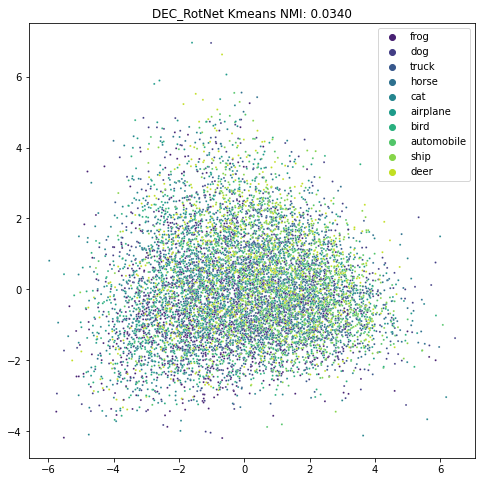

In [32]:
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title(f'{ver} Kmeans NMI: {nmis[ver]:.4f}')
sns.scatterplot(ax=axes, x=pcas[ver][:,0], y=pcas[ver][:,1], hue=lable_classes, s=4, palette='viridis')

In [42]:
model = RotNet(num_classes=4)
state_dict = torch.load(f'trained_models/pretrained_RotNet_features.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

data = load_util.load_custom_cifar('./data', download=False, data_percent=data_percent, for_model='RotNet')
trainloader = torch.utils.data.DataLoader(data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [43]:
embedded_data, labels = model.encode_batchwise(trainloader, device=device, layer=['conv2'], flatten=True)
n_clusters = len(set(labels))
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embedded_data)
nmi = normalized_mutual_info_score(labels, kmeans.labels_)
print(f"NMI: {nmi:.4f}")

NMI: 0.1255


In [ ]:
loss = torch.nn.CrossEntropyLoss()
idec_simclr = IDEC(model, loss, kmeans.cluster_centers_, device)
train_model(idec_simclr, batch_size, 0.001, 50, data, train, device)

Training IDEC_RotNet started...
Number of train images: 80000
IDEC_RotNet: Epoch 1/50 - Iteration 625 - Train loss:1.3793, LR: 0.0001
IDEC_RotNet: Epoch 6/50 - Iteration 3750 - Train loss:1.3796, LR: 0.0001
IDEC_RotNet: Epoch 11/50 - Iteration 6875 - Train loss:1.3795, LR: 0.0001


In [36]:
def train_model(model, batch_size, learning_rate, epochs, data, train, device):
    print(f"Training {model.name} started...")
    model.to(device)

    # paths to save/load models from
    base_path = "trained_models"
    pretrained_model_name = f"pretrained_{model.name}.pth"
    pretrained_model_path = os.path.join(base_path, pretrained_model_name)

    # training
    if train:
        # data_limit = int(len(data) * data_percent)
        # print(f"Number of train images: {data_limit}")
        print(f"Number of train images: {len(data)}")

        # trainloader = torch.utils.data.DataLoader(data[:data_limit],
        trainloader = torch.utils.data.DataLoader(data,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  drop_last=True)

        model = model.fit(trainloader=trainloader, epochs=epochs, start_lr=learning_rate, device=device, model_path=pretrained_model_path)
        torch.save(model.state_dict(), pretrained_model_path)
    else:
        state_dict = torch.load(pretrained_model_path, map_location=device)
        model.load_state_dict(state_dict)

    return model